In [157]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import corner
import json
import math

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('numpy')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference
from pyhf_pymc import infer
from pyhf_pymc import make_op
from pyhf_pymc import plotting

%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
blue = '#1F449C'
pink = '#E57A77'

In [158]:
model = pyhf.Model(
        {'channels': [{'name': 'singlechannel',
        'samples': [
        {'name': 'signal',
        'data': [10, 20, 10],
        'modifiers': [
            {'name': 'mu', 'type': 'normfactor', 'data': None},
            # {'name': 'mu2', 'type': 'normfactor', 'data': None}
            ]},
        {'name': 'background',
        'data': [120, 110, 100],
        'modifiers': [
            # Normalisation Uncertainty / Normal
            {'name': 'normSys', "type": "normsys", "data": {"hi": 1.005, "lo": 0.95}},
            # Correlated / Normal
            {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [200, 200, 200], 'lo_data': [90, 90, 80]}},
            # Staterror / Normal
            {"name": "my_staterror","type": "staterror","data": [10.1, 1.01, 0.101],},
            # # Uncorrelated / Poisson
            # {'name': 'uncorr_bkg', 'type': 'shapesys','data': [40, 51, 62]}
            ]}]}]
            }
        )

data = [110, 105, 100]
auxdata = model.expected_auxdata(model.config.suggested_init())

unconstr_priors = {
    'mu': {'type': 'HalfNormal_Unconstrained', 'sigma': [1.]}
}

In [159]:
prior_dict = prepare_inference.build_priorDict_conjugate(model, unconstr_priors=unconstr_priors)
prior_dict

{'corr_bkg': {'type': 'Normal',
  'mu': array([0.]),
  'sigma': array([0.70710678])},
 'mu': {'type': 'HalfNormal_Unconstrained', 'sigma': [1.0]},
 'normSys': {'type': 'Normal',
  'mu': array([0.]),
  'sigma': array([0.70710678])},
 'my_staterror': {'type': 'Normal',
  'mu': array([0.9929658 , 0.9999157 , 0.99999898]),
  'sigma': array([0.08387012, 0.00918143, 0.00101   ])}}

In [116]:
model.config.auxdata_order

['corr_bkg', 'normSys', 'my_staterror']

In [117]:
model.config.auxdata

[0.0, 0.0, 1.0, 1.0, 1.0]

In [118]:
model.config.suggested_init()

[0.0, 1.0, 0.0, 1.0, 1.0, 1.0]

In [119]:
model.constraint_model.constraints_gaussian.sigmas

Array([1.        , 1.        , 0.08416667, 0.00918182, 0.00101   ],      dtype=float64)

In [166]:
pyhf.set_backend('jax')
with infer.model_conjugate(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data = pm.sample(draws=10_000, chains=1)#, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(10_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [corr_bkg, mu, normSys, my_staterror]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 10 seconds.
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/data/base.py:221: UserWarning: More chains (10000) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Sampling: [Expected_Data]


Sampling: [Expected_Data, corr_bkg, mu, my_staterror, normSys]


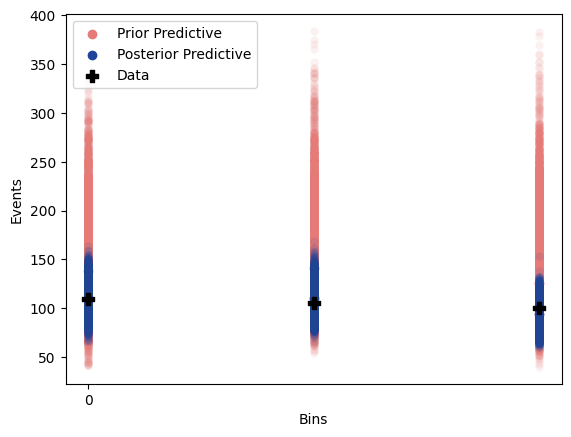

In [167]:
plotting.prior_posterior_predictives(model=model, data=data, post_pred=post_pred, prior_pred=prior_pred, bin_steps=5)

array([[<AxesSubplot: title={'center': 'mu'}>,
        <AxesSubplot: title={'center': 'mu'}>],
       [<AxesSubplot: title={'center': 'normSys'}>,
        <AxesSubplot: title={'center': 'normSys'}>],
       [<AxesSubplot: title={'center': 'corr_bkg'}>,
        <AxesSubplot: title={'center': 'corr_bkg'}>],
       [<AxesSubplot: title={'center': 'my_staterror'}>,
        <AxesSubplot: title={'center': 'my_staterror'}>]], dtype=object)

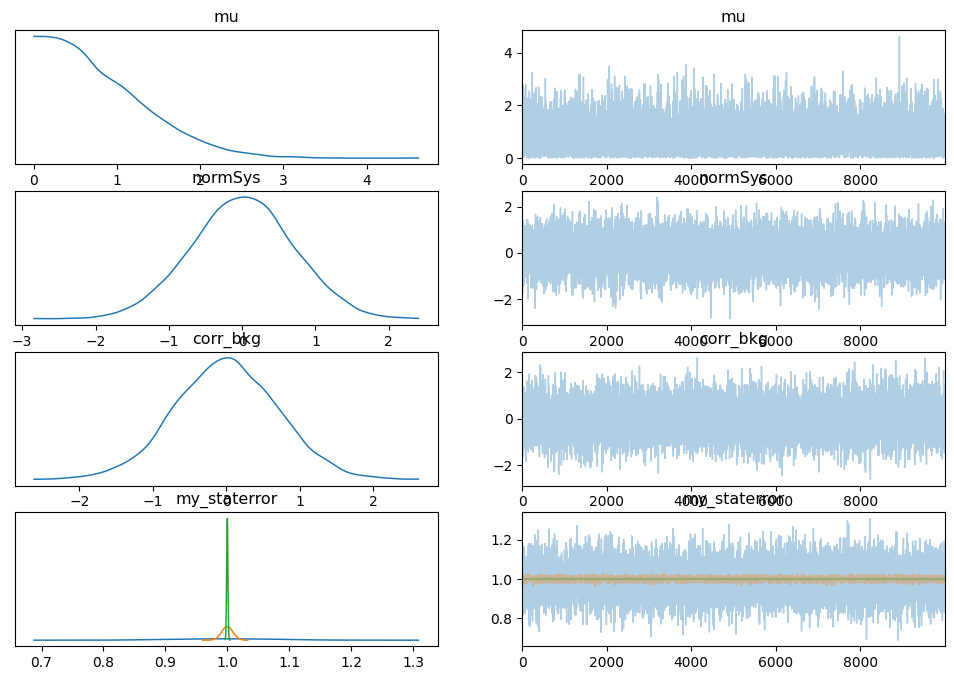

In [168]:
az.plot_trace(prior_pred.prior)

In [11]:
with open('ttbar_ljets_xsec_inclusive_pruned.json') as serialized:
    spec = json.load(serialized)

workspace = pyhf.Workspace(spec)
model = workspace.model()

data = workspace.data(model, include_auxdata=False)

unconstr_priors = {
    'ttbarXsec': {'type': 'HalfNormal_Unconstrained', 'sigma': [0.4]}
}

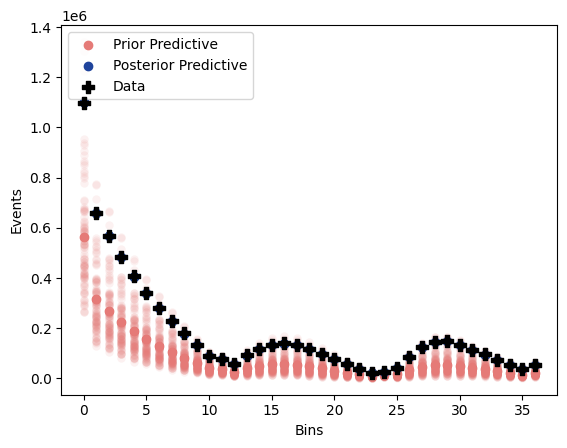

In [28]:
plotting.prior_posterior_predictives(model=model, data=data, post_pred=post_pred, prior_pred=prior_pred, bin_steps=5)

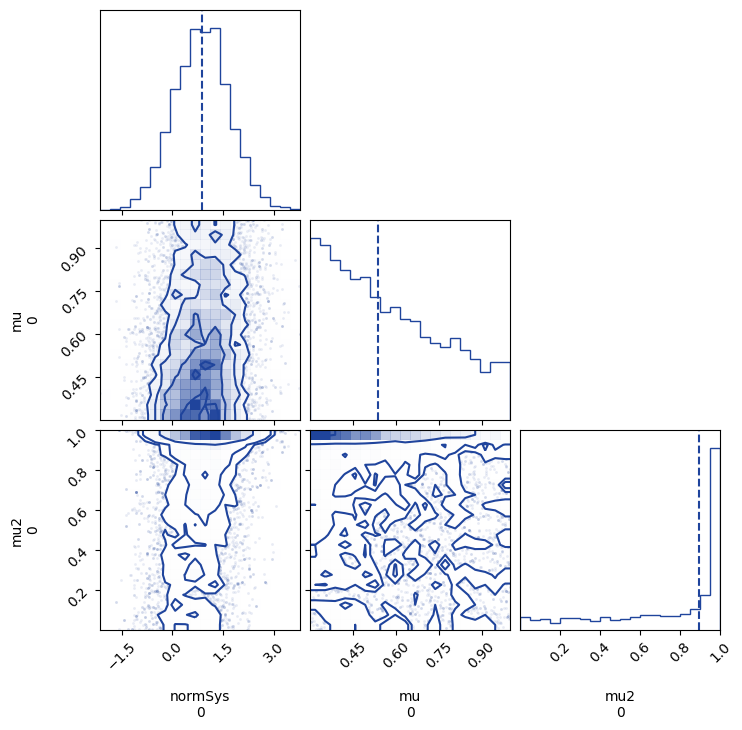

In [133]:
a = corner.corner(post_data.posterior, quantiles=[0.5], color = blue);

In [150]:
xx = np.linspace (0.001, 20, 20) 
for aux in [9.0, 4.652056901191849, 2.6]:
    plt.plot(xx, [sps.gamma.pdf(x, a=aux, scale=1/()) for x in xx], c='k', label='Conjugate Prior')
    plt.plot(xx, [sps.gamma.pdf(x, a=1, scale=1/(1)) for x in xx], '--', label='Ur-Prior')
plt.legend()

TypeError: unsupported operand type(s) for /: 'int' and 'tuple'

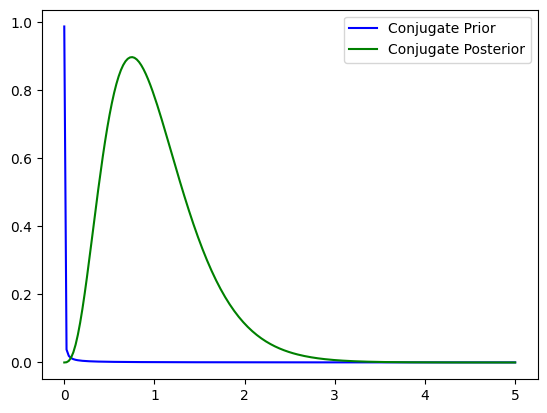

In [233]:
xx = np.linspace (0.001, 5, 200) 

aux = 4
alpha, beta = 0.001, 0.001

plt.plot(xx, [sps.gamma.pdf(x, a=alpha, scale=1/(beta)) for x in xx], c='b', label='Conjugate Prior')
plt.plot(xx, [sps.gamma.pdf(x, a=alpha + aux, scale=1/(aux*(beta + 1))) for x in xx], c='g', label='Conjugate Posterior')

plt.legend()

In [131]:
def get_normalPostHyperpars(aux_mu, aux_sigma, aux_obs, ur_mu, ur_sigma):
    '''
    Returns the (normal) posterior hyperparameters according to the rules of conjufate priors for normal models and ur-priors.
    Args:
        - aux_mu (array): mean hyperparameter of the data-generating model
        - aux_sigma (array)): sigma hyperparameter of the data-generating model
        - aux_obs (array): auxiliary data
        - ur_mu (array): mean hyperparameter of the ur-prior distributuion
        - ur_sigma (array): sigma hyperparameter of the ur-prior distributuion
    Returns:
        - mu (array): hyperparameter mean
        - sigma (array): hyperparameter sigma
    '''
    
    var = (aux_sigma**2 * ur_sigma**2) / (aux_sigma**2 + ur_sigma**2)

    mu = var * ((ur_mu)/(ur_sigma**2) + (aux_obs)/(aux_sigma**2)) 

    return np.array(mu), np.array(np.sqrt(var))

In [100]:
def get_gammaPostHyperpars(aux_obs, ur_alpha, ur_beta):
    '''
    Returns the (normal) posterior hyperparameters according to the rules of conjufate priors for normal models and ur-priors.
    Args:
        - aux_mu (float): mean hyperparameter of the data-generating model
        - aux_sigma (float): sigma hyperparameter of the data-generating model
        - aux_obs (float): auxiliary data
        - ur_mu (float): mean hyperparameter of the ur-prior distributuion
        - ur_sigma (float): sigma hyperparameter of the ur-prior distributuion
    Returns:
        - prior_dict (dictionary): Dictionary of of all parameter priors. Next to the 'name'- and 'type'-keys, the following keys for the constrained
          parameters depend on the distribution type: Normal ('mu', 'sigma'), HalfNormal ('mu'), Gamma ('alpha', 'beta')
    '''
    alpha = ur_alpha + aux_obs
    beta = aux_obs*(ur_beta + 1)

    return np.array(alpha), np.array(beta)

In [124]:
np.array([0, 3])**2

array([0, 9])

In [120]:
get_normalPostHyperpars([0, 0], [1, 1], [0, 0], [1, 1], [1, 1])

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

In [101]:
get_gammaPostHyperpars(9, 0.1, 0.1)

(9.1, 9.9)

In [143]:
def build_priorDict_conjugate(model, unconstr_priors):
    """
    Builds a combined dictionary of constrained parameters (from the model definition) and 
    unconstrained parameters (have to be submitted by hand).

    Args:
        - model:  pyhf model.
        - unconstr_priors (dictionary): Dictionary of unconstrained parameters of the form:
            unconstr_priors = {
                'mu_2': {'type': 'HalfNormal_Unconstrained', 'sigma': [.1]},
                'mu': {'type': 'Gamma_Unconstrained', 'alpha': [5.], 'beta': [1.]}
            }
    Returns:
        - prior_dict (dictionary): Dictionary of of all parameter priors. Next to the 'name'- and 'type'-keys, the following keys for the constrained
          parameters depend on the distribution type: Normal ('mu', 'sigma'), HalfNormal ('mu'), Gamma ('alpha', 'beta')
    """ 

    # Turn partiotion indices to ints
    partition_indices = []
    for array in model.constraint_model.viewer_aux.selected_viewer._partition_indices:
        array = [int(x) for x in array]
        partition_indices.append(array)

    prior_dict = {}
    sigma_counter = 0

    for key, specs in model.config.par_map.items():

        if isinstance(specs['paramset'], pyhf.parameters.constrained_by_normal):
            prior_dict[key] = {}
            prior_dict[key]['type'] = 'Normal'
            mu = np.array(model.config.auxdata)[partition_indices[model.config.auxdata_order.index(key)]]
            
            sigma = []
            for i in partition_indices[model.config.auxdata_order.index(key)]:
                sigma.append(model.constraint_model.constraints_gaussian.sigmas[sigma_counter])
                sigma_counter += 1
            prior_dict[key]['mu'], prior_dict[key]['sigma'] = get_normalPostHyperpars(mu, np.array(sigma), mu, np.full(len(mu), 0), np.full(len(mu), 1))
    
        if isinstance(specs['paramset'], pyhf.parameters.constrained_by_poisson):
            prior_dict[key] = {}
            prior_dict[key]['type'] = 'Gamma'
            prior_dict[key]['alpha'], prior_dict[key]['beta'] = get_gammaPostHyperpars(np.array(model.config.auxdata)[partition_indices[model.config.auxdata_order.index(key)]], 0.01, 0.01)
            
        
        if key in unconstr_priors.keys():
            prior_dict[key] = unconstr_priors[key]

    # Test
    try:
        assert prior_dict.keys() == model.config.par_map.keys()
    except:
        raise ValueError('Order of parameters is different from model.config.par_map.')

    return prior_dict

In [144]:
build_priorDict_conjugate(model, unconstr_priors)

{'corr_bkg': {'type': 'Normal',
  'mu': array([0.]),
  'sigma': array([0.70710678])},
 'mu': {'type': 'HalfNormal_Unconstrained', 'sigma': [1.0]},
 'normSys': {'type': 'Normal',
  'mu': array([0.]),
  'sigma': array([0.70710678])},
 'my_staterror': {'type': 'Normal',
  'mu': array([0.9929658 , 0.9999157 , 0.99999898]),
  'sigma': array([0.08387012, 0.00918143, 0.00101   ])}}

In [107]:
build_priorDict_conjugate(model, unconstr_priors)

{'corr_bkg': {'type': 'Normal', 'mu': array([0.]), 'sigma': [1.0]},
 'mu': {'type': 'HalfNormal_Unconstrained', 'sigma': [1.0]},
 'normSys': {'type': 'Normal', 'mu': array([0.]), 'sigma': [1.0]},
 'uncorr_bkg': {'type': 'Gamma',
  'alpha': array([9.01      , 4.6620569 , 2.61145682]),
  'beta': array([9.09      , 4.69857747, 2.62747138])},
 'my_staterror': {'type': 'Normal',
  'mu': array([1., 1., 1.]),
  'sigma': [0.08416666666666667, 0.009181818181818182, 0.00101]}}

In [110]:
prepare_inference.build_priorDict_conjugate(model, unconstr_priors)

{'corr_bkg': {'type': 'Normal', 'mu': array([0.]), 'sigma': [1.0]},
 'mu': {'type': 'HalfNormal_Unconstrained', 'sigma': [1.0]},
 'normSys': {'type': 'Normal', 'mu': array([0.]), 'sigma': [1.0]},
 'uncorr_bkg': {'type': 'Gamma',
  'alpha': array([9.001     , 4.6530569 , 2.60245682]),
  'beta': array([9.009     , 4.65670896, 2.60405827])},
 'my_staterror': {'type': 'Normal',
  'mu': array([1., 1., 1.]),
  'sigma': [0.08416666666666667, 0.009181818181818182, 0.00101]}}

In [141]:
get_normalPostHyperpars(np.array(model.config.auxdata), np.array(model.constraint_model.constraints_gaussian.sigmas), np.array(model.config.auxdata), np.full(len(model.config.auxdata), 0), np.full(len(model.config.auxdata), 1))

(array([0.        , 0.        , 0.9929658 , 0.9999157 , 0.99999898]),
 array([0.70710678, 0.70710678, 0.08387012, 0.00918143, 0.00101   ]))

In [142]:
get_normalPostHyperpars(np.array(model.config.auxdata), np.array(model.constraint_model.constraints_gaussian.sigmas), np.array(model.config.auxdata), np.full(len(model.config.auxdata), 1), np.full(len(model.config.auxdata), 1))

(array([0.5, 0.5, 1. , 1. , 1. ]),
 array([0.70710678, 0.70710678, 0.08387012, 0.00918143, 0.00101   ]))

In [145]:
model.constraint_model.constraints_gaussian.sigmas

Array([1.        , 1.        , 0.08416667, 0.00918182, 0.00101   ],      dtype=float64)

In [153]:
0.08416667**2/(1+0.08416667**2) * (1/(0.08416667**2))

0.9929658021182469

In [148]:
math.sqrt(0.08416667**2/(1+0.08416667**2))

0.08387012508487875